# FICO Challenge - Explainable machine learning model 
    - Interpreting black box algorithms
    - how to do cost-benefit analysis? 
>**Goal**

> **Methodology** “You can set it up as an exploration of explainable models (i.e., sparse linear models) vs black box models (i.e., neural nets or random forests). Testing both and measuring the tradeoff (i.e., what is the cost of explainability) would make for a good analysis. Also, I'll definitely consider extra points if you could implement a system like this.””

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
import statistics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score,roc_curve, auc,accuracy_score
from sklearn import linear_model,svm
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Read and clean data

In [2]:
df_dic = pd.read_excel('heloc_data_dictionary.xlsx', sheet_name='Data Dictionary')

In [3]:
# Eva - Read in data
df = pd.read_csv('heloc_dataset.csv')
print(df.shape)
df.head() 

(10459, 24)


,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


### Data Preprocessing

In [4]:
# Check for missing values
print("number of missing values: ",sum(df.isnull().values.ravel()))
print(df['RiskPerformance'].value_counts())

number of missing values:  0
Bad     5459
Good    5000
Name: RiskPerformance, dtype: int64


In [5]:
# Recoding target variables
df['target'] = np.where(df['RiskPerformance']== "Bad", 1, 0)
df.target.value_counts()
df = df.drop('RiskPerformance',1)

In [6]:
# Dealing with special value -9: Omit samples without any credit history
cleaned = df[df.MSinceMostRecentInqexcl7days != -9]

print('The number of original data:',len(df))
print('The number of missing data:',len(df)-len(cleaned))
print('The number of cleaned data:',len(cleaned))

print(cleaned.target.value_counts())

numBad = cleaned.target.value_counts()[0]
numGood = cleaned.target.value_counts()[1]
print()
print(numBad/len(cleaned))
print(numGood/len(cleaned))

The number of original data: 10459
The number of missing data: 588
The number of cleaned data: 9871
1    5136
0    4735
Name: target, dtype: int64

0.4796879748758991
0.5203120251241009


In [7]:
#Ruoyu
# Dealing with special value :reorder categorical features: MaxDelq2PublicRecLast12M and MaxDelqEver
df = cleaned
df['MaxDelq2PublicRecLast12M'] = df['MaxDelq2PublicRecLast12M'].replace([6,7,8,9], [5,6,7,7])
df['MaxDelqEver'] = df['MaxDelqEver'].replace([1,2,3,4,5,6,7,8,9], [7,0,1,2,3,4,6,5,7])
des = df.describe()
des.iloc[3] # check min for every cols
#only ExternalRiskEstimate has -9 value

ExternalRiskEstimate                 -9.0
MSinceOldestTradeOpen                -8.0
MSinceMostRecentTradeOpen             0.0
AverageMInFile                        4.0
NumSatisfactoryTrades                 0.0
NumTrades60Ever2DerogPubRec           0.0
NumTrades90Ever2DerogPubRec           0.0
PercentTradesNeverDelq                0.0
MSinceMostRecentDelq                 -8.0
MaxDelq2PublicRecLast12M              0.0
MaxDelqEver                           0.0
NumTotalTrades                        0.0
NumTradesOpeninLast12M                0.0
PercentInstallTrades                  0.0
MSinceMostRecentInqexcl7days         -8.0
NumInqLast6M                          0.0
NumInqLast6Mexcl7days                 0.0
NetFractionRevolvingBurden           -8.0
NetFractionInstallBurden             -8.0
NumRevolvingTradesWBalance           -8.0
NumInstallTradesWBalance             -8.0
NumBank2NatlTradesWHighUtilization   -8.0
PercentTradesWBalance                -8.0
target                            

In [8]:
# Ruoyu
#dealing with ExternalRiskEstimate = -9 use linear regression 
    #train =  ExternalRiskEstimate != -9
    #test = ExternalRiskEstimate = -9

train_External = df[df['ExternalRiskEstimate'] != -9]
test_External = df[df['ExternalRiskEstimate'] == -9]

X_train_External = train_External.drop(train_External.columns[0],axis=1)
Y_train_External = train_External['ExternalRiskEstimate']
X_test_External = test_External.drop(test_External.columns[0],axis=1)
Y_test_External = test_External['ExternalRiskEstimate']

regr = linear_model.LinearRegression()
regr.fit(X_train_External, Y_train_External)
Y_pred_External = regr.predict(X_test_External)
Y_pred_External = Y_pred_External.astype(int)

#combine train_External and predict_External
Y_pred_External = pd.DataFrame({'ExternalRiskEstimate':Y_pred_External},index = [89,639,2662,4133,6522,7851,8721,8771,8921,9176])
neg_External = pd.concat([Y_pred_External, X_test_External], axis=1)

#combine train and test
cleaned_neg9 = pd.concat([neg_External,train_External])
df = cleaned_neg9

In [9]:
# Ruoyu
# Dealing with special -8 use KNN = 5 to replace special value -8
des = df.describe()
des.iloc[3]
col_index = np.array([1, 8, 14,17,18,19,20,21,22])
col_name = np.array(['MSinceOldestTradeOpen', 'MSinceMostRecentDelq', 'MSinceMostRecentInqexcl7days', 
                     'NetFractionRevolvingBurden','NetFractionInstallBurden','NumRevolvingTradesWBalance',
                     'NumInstallTradesWBalance','NumBank2NatlTradesWHighUtilization','PercentTradesWBalance'])
zipped = zip(col_index,col_name)

In [10]:
# Ruoyu

for i,j in zipped:
    train_knn = df[df[j] != -8]  #df['colnames']
    test_knn = df[df[j] == -8] 
    test_index = test_knn.index

    x_train_knn = train_knn.drop(train_knn.columns[i],axis=1)  #.columns[i]
    y_train_knn = train_knn[j]
    x_test_knn  = test_knn.drop(test_knn.columns[i],axis=1)
    y_test_knn  = test_knn[j]

    classifier = KNeighborsClassifier(n_neighbors=5) 
    classifier.fit(x_train_knn, y_train_knn) 
    y_pred_knn = classifier.predict(x_test_knn)  
    y_pred_knn = y_pred_knn.astype(int)


    #combine train and predict
    y_pred_knn = pd.DataFrame({j:y_pred_knn}, index = test_index)
    neg_knn = pd.concat([y_pred_knn, x_test_knn], axis=1)

    train_knn_reorder = pd.concat([y_train_knn, x_train_knn], axis=1) #reorder train_knn
 
    #combine train and test  
    cleaned_neg8 = pd.concat([neg_knn,train_knn_reorder])
    df = cleaned_neg8

#make a copy for the cleaned data. If you need to rerun the code, use cleaned_neg8_all 
cleaned_neg8_all = df
df.describe()

,PercentTradesWBalance,NumBank2NatlTradesWHighUtilization,NumInstallTradesWBalance,NumRevolvingTradesWBalance,NetFractionInstallBurden,NetFractionRevolvingBurden,MSinceMostRecentInqexcl7days,MSinceMostRecentDelq,MSinceOldestTradeOpen,ExternalRiskEstimate,...,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,NumInqLast6M,NumInqLast6Mexcl7days,target
count,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,...,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000
mean,66.451829,1.046905,2.381724,4.056124,57.726573,34.536420,0.491440,7.729511,198.809340,72.066559,...,0.384763,92.359943,5.012157,3.928781,22.635498,1.863844,34.618681,1.455982,1.397123,0.520312
std,22.060938,1.509151,1.606461,3.021385,28.961441,28.904505,5.635815,20.711009,98.019442,9.879350,...,0.993223,11.772876,1.292741,1.489066,12.999924,1.828099,17.953432,2.136161,2.096102,0.499613
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-7.000000,-7.000000,2.000000,33.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,1.000000,2.000000,35.000000,8.000000,0.000000,-7.000000,133.000000,64.000000,...,0.000000,89.000000,5.000000,4.000000,13.000000,0.000000,21.000000,0.000000,0.000000,0.000000
50%,67.000000,1.000000,2.000000,3.000000,61.000000,29.000000,0.000000,1.000000,184.000000,72.000000,...,0.000000,97.000000,5.000000,4.000000,21.000000,1.000000,33.000000,1.000000,1.000000,1.000000
75%,83.000000,2.000000,3.000000,5.000000,82.000000,56.000000,1.000000,15.000000,256.000000,80.000000,...,0.000000,100.000000,6.000000,5.000000,30.000000,3.000000,45.000000,2.000000,2.000000,1.000000
max,100.000000,18.000000,23.000000,32.000000,471.000000,232.000000,24.000000,83.000000,803.000000,94.000000,...,19.000000,100.000000,7.000000,6.000000,104.000000,19.000000,100.000000,66.000000,66.000000,1.000000


In [11]:
#replace -7 with a large number
df['MSinceMostRecentInqexcl7days'] = df['MSinceMostRecentInqexcl7days'].replace(-7,200) 
df['MSinceMostRecentDelq'] = df['MSinceMostRecentDelq'].replace(-7,200)

- Replace -8 s with value of nearest point

In [167]:
# SunJoo
# Train Test Split data
X = df.drop('target',axis=1)
y = df['target']

# setseed
np.random.seed(123)

# Using 20% of data for test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
train = df.loc[df.index.isin(X_train.index), :]
test = df.loc[~df.index.isin(X_train.index), :]

#np.shape(train)

In [168]:
# Normalize
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

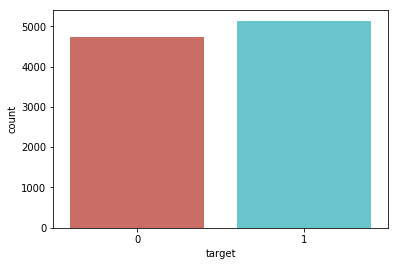

<Figure size 432x288 with 0 Axes>

In [14]:
# plot the count of target
sns.countplot(x='target',data= df,palette='hls')
plt.show()
plt.savefig('count_plt')

In [169]:
X_test

array([[ 0.28726543, -0.69363555,  0.3741147 , ..., -0.20856438,
        -0.214519  , -0.19064342],
       [ 0.01475413, -0.69363555, -0.85672266, ..., -1.54953552,
        -0.214519  , -0.19064342],
       [ 0.8777066 , -0.69363555, -0.24130398, ..., -0.59968096,
        -0.67795048, -0.66312317],
       ...,
       [-1.0752911 , -0.69363555, -0.85672266, ..., -1.21429274,
        -0.214519  , -0.19064342],
       [ 0.83228805,  1.29028608,  0.3741147 , ...,  0.23842601,
        -0.67795048, -0.66312317],
       [ 0.37810254,  1.95159329, -0.85672266, ..., -1.32604033,
        -0.67795048, -0.66312317]])

In [170]:
df_sample = y.sample(n=1000)
df_sample

4838     0
8794     0
3461     1
10316    0
867      1
4690     0
10114    1
104      0
2097     0
3064     1
1814     1
1658     1
6395     1
8562     0
4626     0
1542     1
4386     1
427      1
4585     0
3846     0
5938     1
8067     0
5272     1
4991     0
360      0
8228     1
3823     0
4977     0
844      1
4909     0
        ..
1055     0
9192     1
6998     1
2441     1
8419     1
7477     0
6871     0
611      0
9848     0
5688     1
5372     0
3783     0
4126     1
10296    1
8746     1
3375     1
9353     1
2685     0
389      1
9576     0
10272    0
10057    1
2734     0
7279     1
10344    1
4011     0
2121     1
6011     0
1682     0
503      1
Name: target, Length: 1000, dtype: int64

In [17]:
import random

In [18]:
#plot the distribution of the target variable
target_f = []
for i in range(10000):
    rand_n = random.randint(1000,8000)
    df_sample = y.sample(n=rand_n)
    count = len(df_sample[df_sample==1])/rand_n
    target_f.append(count)  

Text(0,0.5,'Probability')

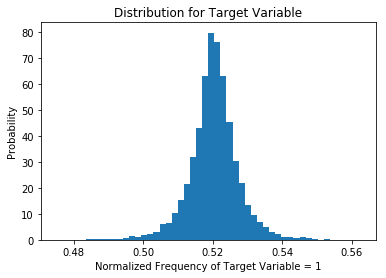

In [171]:
plt.figure()
plt.hist(target_f, bins=50,density = True)
plt.title("Distribution for Target Variable")
plt.xlabel("Normalized Frequency of Target Variable = 1")
plt.ylabel("Probability")

## Baseline Model

In [172]:
#ZC 11/12/2018
mean_RiskEstimate = np.mean(train['ExternalRiskEstimate'])
mean_RiskEstimate
#a naive baseline model: if risk estimate > mean(risk estimate), set "Good", otherwise "Bad"
test['naive_base'] = np.zeros(len(test))
test.loc[test['ExternalRiskEstimate'] < mean_RiskEstimate,'naive_base'] = 1

#calulate accuracy on the test set
count = 0
for index,row in test.iterrows():
    if row['naive_base'] == row['target']:
        count+=1
accuracy_baseline = count/len(test)
print('The accuracy of baseline model on test set: {:.4f}'.format(accuracy_baseline))

The accuracy of baseline model on test set: 0.7043


In [173]:
#ZC 11/15/2018
#Calculate AUC for the baseline model
fpr_base, tpr_base, thresholds_base = roc_curve(test["target"], test["naive_base"])
roc_auc_base = auc(fpr_base, tpr_base)
print('AUC of baseline model: {:.4f}' .format(roc_auc_base))

AUC of baseline model: 0.7055


## Initial Training

### Improved Baseline

In [22]:
#12/3/2018 modified scoring function:change score/threshold to the distance to the mean from train data
#it is equivalent to a simple decision tree/hyperplane problem where the level of mean divides the whole space to 1 and 0 while a distance loss function is applied

#isolate the target and base prediction as a seperate dataframe
df_baseline = test.loc[:,['ExternalRiskEstimate','target','naive_base']]

#drop the colume "naive_base" in the original dataset
test.drop(["naive_base"],axis=1,inplace=True)

#create scores based on the distance of ExternalRiskEstimate to mean_RiskEstimate, the more negative it is the higher the score
#aka the more likely the instance is of a positive case (a score of "Bad")
df_baseline['score'] = df_baseline['ExternalRiskEstimate'] -  mean_RiskEstimate

#sort the dataframe based on score (ascendingly by the value = decendingly by the ranking, remember the lower the score the higher the ranking)
df_baseline.sort_values(by=['score'],inplace = True)
#df_baseline.head()


In [23]:
#for improved baseline
#apply the score to the roc function to obtain fpr and tpr
fpr_base_1, tpr_base_1, thresholds_base_1 = roc_curve(df_baseline["target"], df_baseline["score"])
thresholds_base_1 

array([ 22.04090679,  21.04090679,  20.04090679,  19.04090679,
        18.04090679,  17.04090679,  16.04090679,  15.04090679,
        14.04090679,  13.04090679,  12.04090679,  11.04090679,
        10.04090679,   9.04090679,   8.04090679,   7.04090679,
         6.04090679,   5.04090679,   4.04090679,   3.04090679,
         2.04090679,   1.04090679,   0.04090679,  -0.95909321,
        -1.95909321,  -2.95909321,  -3.95909321,  -4.95909321,
        -5.95909321,  -6.95909321,  -7.95909321,  -8.95909321,
        -9.95909321, -10.95909321, -11.95909321, -12.95909321,
       -13.95909321, -14.95909321, -15.95909321, -16.95909321,
       -17.95909321, -18.95909321, -20.95909321, -21.95909321,
       -25.95909321, -26.95909321, -35.95909321])

In [24]:
#to get the index of threshold  values
row_n = []
for t in thresholds_base_1[1:]:
    row_n.append(df_baseline.loc[df_baseline["score"] == t].index.values[-1])
row_n_sorted = list(reversed(row_n))

In [25]:
#calculate tpr and fpr by moving along the threshold
true_p=df_baseline[df_baseline["target"]==1].count()[0]
true_n=len(df_baseline) - true_p
tpr_base_2 = []
fpr_base_2 = []
n_pred_base_2 = []

for i in row_n_sorted:
    df_threshold = df_baseline.loc[:i]
    #assume all instances above certain threshold is positive
    #true value of positive predictions made so far 
    positive_t = df_threshold[df_baseline["target"]==1].count()[0]
    negative_t = df_threshold[df_baseline["target"]!=1].count()[0]
    #tpr and fpr
    tpr = positive_t/true_p
    fpr = negative_t/true_n
    tpr_base_2.append(tpr)
    fpr_base_2.append(fpr)
    n_pred_base_2.append(len(df_threshold)/len(df_baseline))

In [26]:
#AUC for improved baseline
roc_auc_base_2 = auc(fpr_base_2, tpr_base_2)
print("The auc is: ",roc_auc_base_2)
accuracy_baseline_improved = accuracy_score(df_baseline["target"],df_baseline["naive_base"])
print("The accuracy is: ", accuracy_baseline_improved)

The auc is:  0.7746991578268275
The accuracy is:  0.7043037974683545


In [27]:
size_1 = df_baseline.loc[df_baseline['naive_base'] == 1].count()[0]
#therefore the proportion of prediction in population is
size_pred = [0,size_1/len(test),1]
size_pred
#this will be used in PnL Analysis (cost and benefit)

[0, 0.48050632911392405, 1]

### Logistic Regression

In [174]:
#Eva 
#Use default settings
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print()

accuracy_lr = logreg.score(X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(accuracy_lr))

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(logreg.coef_))], axis = 1)
print(coefficients)


Accuracy of logistic regression classifier on test set: 0.7291
                                     0         0
0                PercentTradesWBalance -0.089690
1   NumBank2NatlTradesWHighUtilization  0.152542
2             NumInstallTradesWBalance -0.029664
3           NumRevolvingTradesWBalance  0.207679
4             NetFractionInstallBurden  0.017136
5           NetFractionRevolvingBurden  0.250215
6         MSinceMostRecentInqexcl7days  0.126899
7                 MSinceMostRecentDelq -0.150750
8                MSinceOldestTradeOpen -0.080562
9                 ExternalRiskEstimate -0.533991
10           MSinceMostRecentTradeOpen  0.059830
11                      AverageMInFile -0.252653
12               NumSatisfactoryTrades -0.446252
13         NumTrades60Ever2DerogPubRec -0.005985
14         NumTrades90Ever2DerogPubRec  0.020355
15              PercentTradesNeverDelq -0.175566
16            MaxDelq2PublicRecLast12M -0.089134
17                         MaxDelqEver  0.093030
18   

In [29]:
# accuracy, fpr, tpr, thresholds, and auc for default Logistic regression
accuracy_logreg = accuracy_score(y_test, y_pred)

logreg_pred = logreg.predict_proba(X_test)[:,1]
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_pred)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_logreg =  roc_auc_logreg

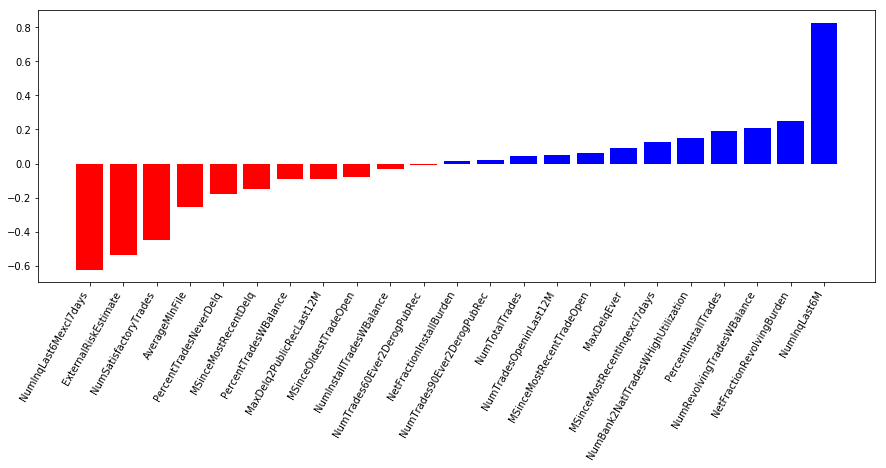

In [30]:
# Plot feature coefficients
coef = logreg.coef_.ravel()
sort_idx = np.argsort(coef)

plt.figure(figsize=(15, 5))
colors = []
for c in np.sort(coef):
    if c < 0:
        colors.append('red')
    else:
        colors.append('blue')
        
plt.bar(np.array(df.columns)[sort_idx], np.sort(coef), color=colors)
feature_names = np.array(np.array(df.columns)[sort_idx])
plt.xticks(feature_names, rotation=60, ha='right')
plt.show()

- The result is slight higher than baseline model, next we performed grid search with cross-validation to find the best hyper-parameter combinations.

In [31]:
# Logistic Regression with Grid Search CV
# Perform a grid search to optimize hyper-parameters using cross-validation
# Create folds for cross-validation, use Kfold to create 4 folds
kfolds = KFold(n_splits = 4)
#1et up a paramater grid
param_grid_lr = {'C':[10**i for i in range(-2, 3)], 'penalty':['l1', 'l2']}

#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
lr_grid_search = GridSearchCV(linear_model.LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'accuracy') 
lr_grid_search.fit(X_train, y_train)

#3rd, get the score of the best model and print it
best_1 = lr_grid_search.best_score_
print('Score of the best model: {:.4f}'.format(best_1,'\n'))
# look at the best-estimator chosen to see what the parameters were
print(lr_grid_search.best_estimator_)
best_grid = lr_grid_search.best_estimator_
y_pred =best_grid.predict(X_test)
print('Accuracy of logistic regression with Grid Search CV on test set: {:.4f}'.format(accuracy_score(y_test, y_pred)))

Score of the best model: 0.7278
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of logistic regression with Grid Search CV on test set: 0.7332


In [32]:
# Create pipline to perform gridSearch
# Generate polynomial and interaction terms
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

steps_poly = [('polyfeat', PolynomialFeatures()),
              ('scaler', StandardScaler()),
         ('lr', LogisticRegression())]

#Now set up the pipeline
pipeline_poly = Pipeline(steps_poly)

#Now set up a new parameter grid, use the same paramaters used above for logistic regression, but add polynomial features up to degree 3. 
parameters_poly = dict(polyfeat__degree = [1, 2],
                       polyfeat__interaction_only = [True, False],
                       lr__C = [10**i for i in range(-2, 3)],
                       lr__penalty = ['l1', 'l2'])

#Now run another grid search
lr_grid_search_poly = GridSearchCV(pipeline_poly, param_grid = parameters_poly, cv = kfolds, scoring = 'accuracy')

lr_grid_search_poly.fit(X_train, y_train)
best_2 = lr_grid_search_poly.best_score_
print('Score of the best model: {:.4f}'.format(best_2,'\n'))

best_grid_2 = lr_grid_search_poly.best_estimator_
print(best_grid_2,'\n')
y_pred_2 =best_grid_2.predict(X_test)
print('Accuracy of logistic regression with Grid Search CV and polynomial features on test set: {:.4f}'.format(accuracy_score(y_test, y_pred_2)))


Score of the best model: 0.7278
Pipeline(memory=None,
     steps=[('polyfeat', PolynomialFeatures(degree=1, include_bias=True, interaction_only=True)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]) 

Accuracy of logistic regression with Grid Search CV and polynomial features on test set: 0.7332


In [33]:
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, random_state = 42)

In [34]:
cvs_rl = cross_val_score(best_grid_2, X_test, y_test, cv=kfold)
print(cvs_rl.mean(),cvs_rl.std())

0.7306004204481361 0.02447433425600565


In [35]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lr_grid_search_poly.best_estimator_.steps[-1][1].coef_)[1:])], axis = 1)
print(coefficients)
print(lr_grid_search_poly.best_estimator_.steps[0][1].get_params())
#lr_grid_search_poly.best_estimator_.steps[0][1].get_feature_names()

                                     0         0
0                PercentTradesWBalance -0.046029
1   NumBank2NatlTradesWHighUtilization  0.149869
2             NumInstallTradesWBalance -0.022712
3           NumRevolvingTradesWBalance  0.169788
4             NetFractionInstallBurden  0.008723
5           NetFractionRevolvingBurden  0.223373
6         MSinceMostRecentInqexcl7days  0.118612
7                 MSinceMostRecentDelq -0.128039
8                MSinceOldestTradeOpen -0.070593
9                 ExternalRiskEstimate -0.557180
10           MSinceMostRecentTradeOpen  0.043969
11                      AverageMInFile -0.247985
12               NumSatisfactoryTrades -0.382292
13         NumTrades60Ever2DerogPubRec  0.000000
14         NumTrades90Ever2DerogPubRec  0.000000
15              PercentTradesNeverDelq -0.161067
16            MaxDelq2PublicRecLast12M -0.074349
17                         MaxDelqEver  0.055042
18                      NumTotalTrades  0.000000
19              NumT

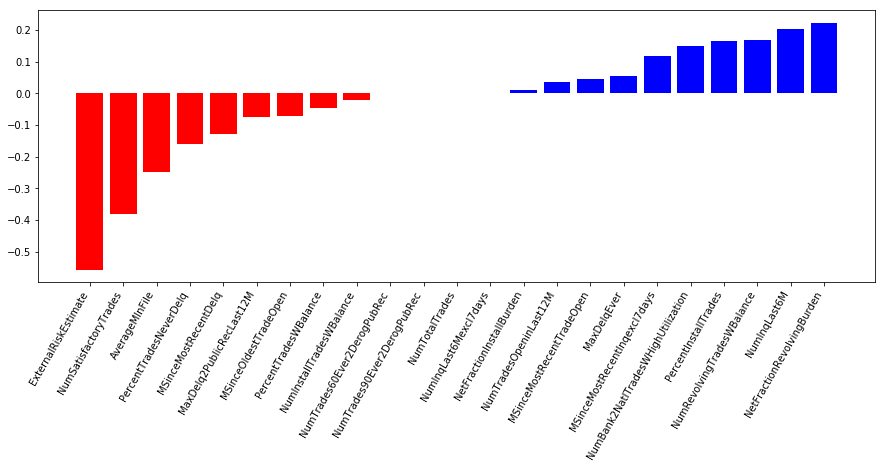

In [36]:
# Plot feature coefficients
coef = lr_grid_search_poly.best_estimator_.steps[-1][1].coef_[0][1:]
sort_idx = np.argsort(coef)

plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in np.sort(coef)]
plt.bar(np.array(df.columns)[sort_idx], np.sort(coef), color=colors)
feature_names = np.array(np.array(df.columns)[sort_idx])
plt.xticks(feature_names, rotation=60, ha='right')
plt.show()


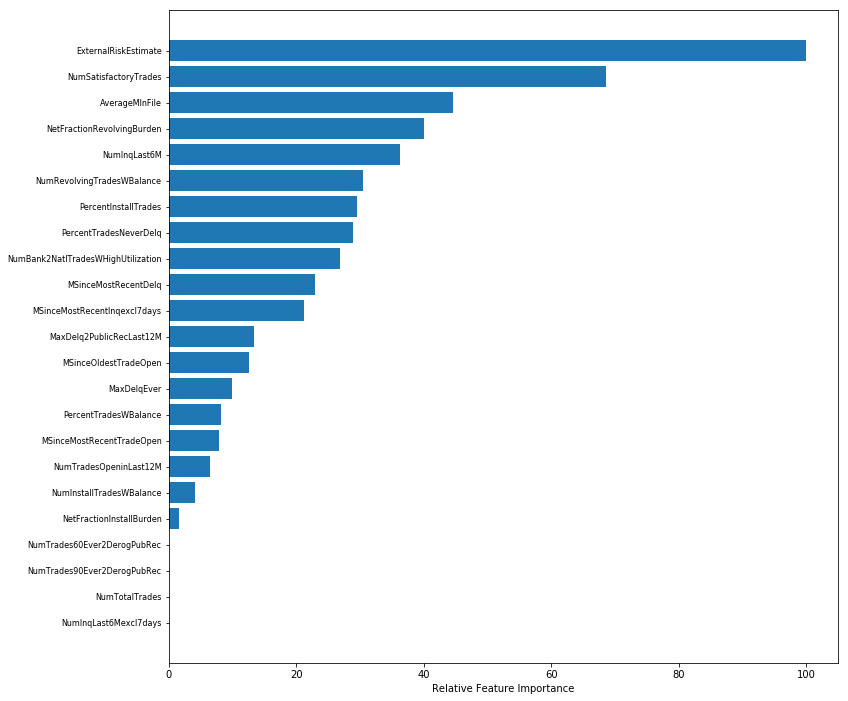

In [116]:
# Plot feature importance for logistic regression

feature_importance = abs(lr_grid_search_poly.best_estimator_.steps[-1][1].coef_[0][1:])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(12,12))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(df.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

#plt.tight_layout()   
plt.show()

#fi_list = pd.DataFrame({'feature':np.array(df.columns)[sorted_idx], 'feature importance':feature_importance[sorted_idx]})
#print(fi_list)

In [38]:
#calculate AUC for logit based on predicted values vs the actual target value in the test set
logit_pred = logreg.predict_proba(X_test)[:,1]
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, logit_pred)
roc_auc_logit = auc(fpr_logit, tpr_logit)
print('AUC of the best logsitic regression model: {:.4f}'.format(roc_auc_logit))

AUC of the best logsitic regression model: 0.8066


In [39]:
# accuracy, fpr, tpr, thresholds, and auc for Logistic regression
accuracy_logreg = accuracy_score(y_test, y_pred_2)

logreg_pred = best_grid_2.predict_proba(X_test)[:,1]
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_pred)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_logreg =  roc_auc_logreg

- exponential of Coeficients represent the ratio change in the odds of the event of interest for a one-unit change in the predictor.
- There are some unavoidable multicollinearities in the HELOC dataset which will affect the performance or LR. Therefore we add polynomial and interaction features to the model to capture those nonlineary and multicollinearities. 


In [149]:
#Delete
# Fit the model again after feature selection top 10
# Logistic Regression with Grid Search CV
# Perform a grid search to optimize hyper-parameters using cross-validation
X_10 = X[['MSinceMostRecentDelq', 'NumBank2NatlTradesWHighUtilization',
       'PercentTradesNeverDelq', 'PercentInstallTrades',
       'NumRevolvingTradesWBalance', 'NumInqLast6M',
       'NetFractionRevolvingBurden', 'AverageMInFile',
       'NumSatisfactoryTrades', 'ExternalRiskEstimate']]

X_test10 = X_10.loc[~X_10.index.isin(X_train.index), :]
X_train10 = X_10.loc[X_10.index.isin(X_train.index),:]

kfolds = KFold(n_splits = 4)
#1et up a paramater grid
param_grid_lr = {'C':[10**i for i in range(-2, 3)], 'penalty':['l1', 'l2']}

#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
lr_grid_search = GridSearchCV(linear_model.LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'accuracy') 
lr_grid_search.fit(X_train10, y_train)

#3rd, get the score of the best model and print it
best_1 = lr_grid_search.best_score_
print('Score of the best model: {:.4f}'.format(best_1,'\n'))
# look at the best-estimator chosen to see what the parameters were
print(lr_grid_search.best_estimator_)
best_grid = lr_grid_search.best_estimator_
y_pred =best_grid.predict(X_test10)
print('Accuracy of logistic regression with Grid Search CV on test set: {:.4f}'.format(accuracy_score(y_test, y_pred)))

# accuracy, fpr, tpr, thresholds, and auc for Logistic regression
accuracy_logreg = accuracy_score(y_test, y_pred)

logreg_pred = best_grid.predict_proba(X_test10)[:,1]
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_pred)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_logreg =  roc_auc_logreg
print(auc_logreg)

Score of the best model: 0.5106
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of logistic regression with Grid Search CV on test set: 0.5230
0.509618525755213


### Support Vector Machine

In [176]:
#Eva - SVM with default settings
svmm = svm.SVC()
svmm.fit(X_train, y_train)
svm_score = svmm.score(X_test, y_test)
print(svmm)
#test accuracy for svm
cvs_svm = cross_val_score(svmm, X_test, y_test, scoring='accuracy', cv=kfold)
print('test accuracy cvm:{:.4f}' .format(cvs_svm.mean()))
#calculate AUC for SVM 
svm_pred = svmm.decision_function(X_test)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_pred)
roc_auc_svm = auc(fpr_svm, tpr_svm)
print('AUC of svm baseline model: {:.4f}' .format(roc_auc_svm))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
test accuracy cvm:0.7291
AUC of svm baseline model: 0.8006


In [177]:
# SVM with Grid Search using cross-validation
Cs = [0.1, 1]
gammas = [0.001, 0.01, 0.1]
param_grid = {'C': Cs,'gamma':gammas}
grid_search_svm = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=4,scoring = 'accuracy')
grid_search_svm.fit(X_train, y_train)
print(grid_search_svm.best_params_)
print(grid_search_svm.score(X_train, y_train))
best_grid_svm = grid_search_svm.best_estimator_
best_grid_svm 
cvs_svm = cross_val_score(best_grid_svm, X_test, y_test, scoring='accuracy', cv=kfold)
print('test accuracy of svm model: {:.4f}' .format(cvs_svm.mean()))
#calculate auc for SVM grid
svm_pred_best = grid_search_svm.decision_function(X_test)
fpr_svm_best, tpr_svm_best, thresholds_svm_best = roc_curve(y_test, svm_pred_best)
roc_auc_svm_best = auc(fpr_svm_best, tpr_svm_best)
print('AUC of svm model: {:.4f}' .format(roc_auc_svm_best))

{'C': 1, 'gamma': 0.01}
0.7356889564336373
0.7331513100548633
AUC of svm model: 0.8099





- For 'rbf' kernal, it's not possible to find coef_ given data are transformed by kernal method to another space.

### Decision Trees

In [47]:
#ZC
from sklearn import tree

#decision trees using the default setting
df_entropy = tree.DecisionTreeClassifier(criterion="entropy")
df_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

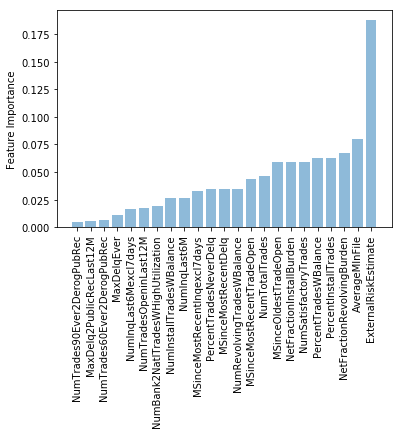

In [48]:
#to look at the features in detail
%matplotlib inline

feature_importance = df_entropy.feature_importances_
feature_names = list(train.drop('target',1))
feature_result = dict(zip(feature_names, feature_importance))
feature_result_sorted = dict(sorted(feature_result.items(), key = lambda x:x[1]) )
feature_result_sorted 

x_pos = np.arange(len(feature_names))

plt.bar(x_pos, feature_result_sorted.values(), align='center', alpha=0.5 )
plt.xticks(x_pos, feature_result_sorted.keys(), rotation=90)
plt.ylabel('Feature Importance')

plt.show()

In [49]:
# to predict and calculate AUC  without any tuning
dt_pred = df_entropy.predict(X_test)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dt_pred)
roc_auc_dt = auc(fpr_dt, tpr_dt)
print("The accuracy is: ", accuracy_score(y_test, dt_pred))

The accuracy is:  0.6258227848101265


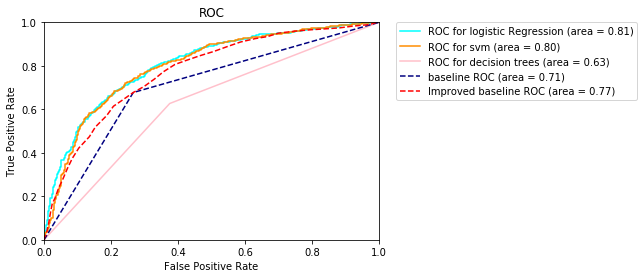

In [50]:
#first comparison
#ZC -to compare the models so far based on roc and auc, not tuned
plt.figure()

plt.plot(fpr_logit, tpr_logit,color='aqua', label='ROC for logistic Regression (area = %0.2f)' % roc_auc_logit)
plt.plot(fpr_svm, tpr_svm,color='darkorange',label='ROC for svm (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_dt, tpr_dt,color='pink',label='ROC for decision trees (area = %0.2f)' % roc_auc_dt)
plt.plot(fpr_base, tpr_base, color='navy', linestyle='--',label='baseline ROC (area = %0.2f)' % roc_auc_base)
plt.plot(fpr_base_2, tpr_base_2, color='red', linestyle='--',label='Improved baseline ROC (area = %0.2f)' % roc_auc_base_2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [51]:
#see why the performance of decision tree is poor

min_samples_leaf_values = np.linspace(200,1,num = 100, dtype = int)

train_accuracy = []
test_accuracy = []

#for split in min_samples_split_values:
for leaf_num in min_samples_leaf_values:
    df_entropy_new = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf= leaf_num)
    df_entropy_new.fit(X_train, y_train)
    test_df_pred_new = df_entropy_new.predict(X_test)
    train_df_pred_new = df_entropy_new.predict(X_train)
    accuracy_test_df_new = accuracy_score(y_test,test_df_pred_new)
    accuracy_train_df_new = accuracy_score(y_train,train_df_pred_new)
    df_entropy_result_test = [leaf_num,accuracy_test_df_new]
    df_entropy_result_train = [leaf_num,accuracy_train_df_new]
    test_accuracy.append(df_entropy_result_test)
    train_accuracy.append(df_entropy_result_train)

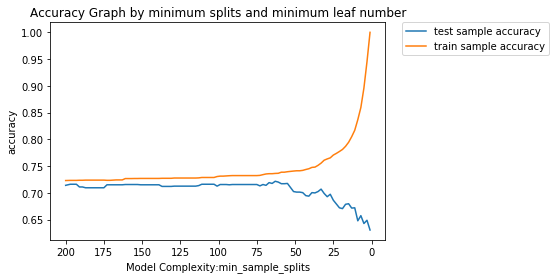

In [52]:
%matplotlib inline

plt.figure()
plt.plot([x[0] for x in test_accuracy],[x[1] for x in test_accuracy],label="test sample accuracy")
plt.plot([x[0] for x in train_accuracy],[x[1] for x in train_accuracy],label="train sample accuracy")
plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title("Accuracy Graph by minimum splits and minimum leaf number")
plt.xlabel("Model Complexity:min_sample_splits")
plt.ylabel("accuracy")

plt.show()

In [53]:
#As suspected, the low accuracy and AUC suffers from overfitting
#therefore, we now try to find the hyper perimeter that optimize the model

#split the data train/val/test = 70/10/20
val_1 = train.sample(frac=0.1)
train_1 = train.iloc[~train.index.isin(val_1.index), :]

In [54]:
#use validation set to find perimeters
import math

min_samples_split_values = np.linspace(2,1000,num = 10, dtype = int)
min_samples_leaf_values = np.linspace(200,2,num = 10, dtype = int)

df_entropy_list = []
df_entropy_classifier_list = []

for split in min_samples_split_values:
    for leaf_num in min_samples_leaf_values:
        df_entropy_new = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf= int(math.ceil(leaf_num)), min_samples_split = int(math.ceil(split)))
        df_entropy_new.fit(train_1.drop('target',1), train_1['target'])
        test_df_pred_new = df_entropy_new.predict(val_1.drop('target',1))
        accuracy_test_df_new = accuracy_score(val_1['target'],test_df_pred_new)
        df_entropy_result = [split,leaf_num,accuracy_test_df_new*100]
        df_entropy_list.append(df_entropy_result)
        df_entropy_classifier_list.append(df_entropy_new)

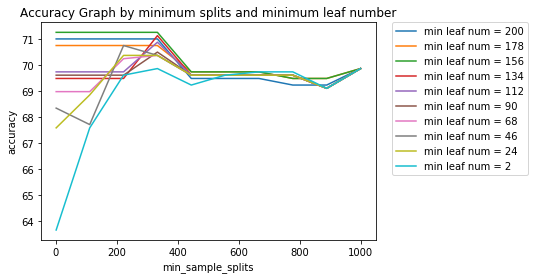

In [55]:
#creat a dataframe from the previous result
header_1 = ["min_split","min_leaf_num","accuracy"]
result_df= pd.DataFrame(df_entropy_list, columns=header_1)

#draw the graph
for leaf_num in min_samples_leaf_values:
    plt.plot(result_df.loc[result_df["min_leaf_num"]==leaf_num,"min_split"],result_df.loc[result_df["min_leaf_num"]==leaf_num,"accuracy"],label="min leaf num = "+str(leaf_num))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title("Accuracy Graph by minimum splits and minimum leaf number")
plt.xlabel("min_sample_splits")
plt.ylabel("accuracy")

plt.show()

In [56]:
result = result_df.loc[result_df["accuracy"].idxmax()]
leaf_num = result[1]
split = result[0]
result
#min_split = 2, min_leaf_num = 200

min_split         2.000000
min_leaf_num    156.000000
accuracy         71.265823
Name: 2, dtype: float64

In [57]:
df_entropy_new = tree.DecisionTreeClassifier(criterion="entropy",min_samples_split=int(split),min_samples_leaf = int(leaf_num))
df_entropy_new.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=156, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [58]:
#calculate on the test set use predit (brut force label)
dt_pred_1 = df_entropy_new.predict(X_test)
print("The accuracy for the test data is: ", accuracy_score(y_test,df_entropy_new.predict(X_test)))
fpr_dt_1, tpr_dt_1, thresholds_dt_1 = roc_curve(y_test, dt_pred_1)
roc_auc_dt_1 = auc(fpr_dt_1, tpr_dt_1)
print("The auc is: ",roc_auc_dt_1 )

The accuracy for the test data is:  0.7154430379746836
The auc is:  0.7163890926349398


In [59]:
#try predit_proba (more granuler)
dt_pred_2 = df_entropy_new.predict_proba(X_test)[:,1]
fpr_dt_2, tpr_dt_2, thresholds_dt_2 = roc_curve(y_test, dt_pred_2)
roc_auc_dt_2 = auc(fpr_dt_2, tpr_dt_2)
print("The auc for improved decision tree is: ",roc_auc_dt_2)
accuracy_score(y_test,df_entropy_new.predict(X_test))

The auc for improved decision tree is:  0.7796589188378462


0.7154430379746836

In [60]:
len(thresholds_dt_2)

39

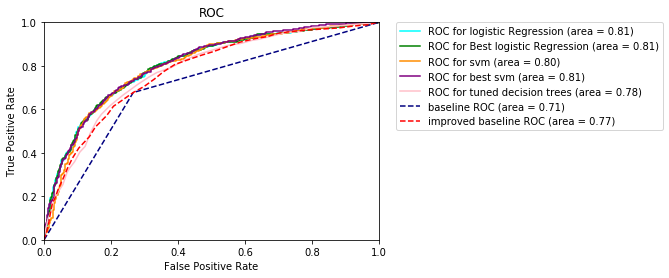

In [61]:
#plot the AUC and ROC of the test set
plt.figure()

plt.plot(fpr_logit, tpr_logit,color='aqua', label='ROC for logistic Regression (area = %0.2f)' % roc_auc_logit)
plt.plot(fpr_logreg, tpr_logreg,color='green', label='ROC for Best logistic Regression (area = %0.2f)' % roc_auc_logreg)
plt.plot(fpr_svm, tpr_svm,color='darkorange',label='ROC for svm (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_svm_best, tpr_svm_best,color='purple',label='ROC for best svm (area = %0.2f)' % roc_auc_svm_best)
plt.plot(fpr_dt_2, tpr_dt_2,color='pink',label='ROC for tuned decision trees (area = %0.2f)' % roc_auc_dt_2)
plt.plot(fpr_base, tpr_base, color='navy', linestyle='--',label='baseline ROC (area = %0.2f)' % roc_auc_base)
plt.plot(fpr_base_2, tpr_base_2, color='red', linestyle='--',label='improved baseline ROC (area = %0.2f)' % roc_auc_base_2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Random Forest

In [62]:
# SunJoo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

rf =  RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print("The accuracy of training set: {:.3f}".format(rf.score(X_train, y_train)))
print("The accuracy of test set: {:.3f}".format(rf.score(X_test, y_test)))

The accuracy of training set: 1.000
The accuracy of test set: 0.730


In [63]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_prob_rf = rf.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, threshold = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print("AUC for random forest is: ", roc_auc_rf)

AUC for random forest is:  0.7980227729871774


In [64]:
#Random Search for RF
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(100, 700).astype(int),
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True]
}

# Create the random search model
rs = RandomizedSearchCV(rf, param_grid, n_jobs = -1, cv = 4, 
                        n_iter = 10, verbose = 1, random_state=42)

# Fit 
rs.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([100, 112, 124, 136, 148, 161, 173, 185, 197, 210, 222, 234, 246,
       259, 271, 283, 295, 308, 320, 332, 344, 357, 369, 381, 393, 406,
       418, 430, 442, 455, 467, 479, 491, 504, 516, 528, 540, 553, 565,
       577, 589, 602, 614, 626, 638, 651, 663, 675, 687, 700]), 'max_features': ['auto', 'sqrt'], 'bootstrap': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_tr

In [65]:
rs.best_params_

{'n_estimators': 504, 'max_features': 'sqrt', 'bootstrap': True}

In [66]:
n_est = [200, 500, 700, 1000]
m_feat = [3, 5, 7]

aucs_test = {}

lab = 'target'

for m in m_feat:
    aucs_test[m] = []
    for n in n_est:
        rf_oob = RandomForestClassifier(criterion='entropy', n_estimators=n, max_features=m, oob_score=True)
        rf_oob = rf_oob.fit(train.drop(lab, 1), train[lab])
        aucs_test[m].append(roc_auc_score(test[lab], rf_oob.predict_proba(test.drop(lab,1))[:,1]))

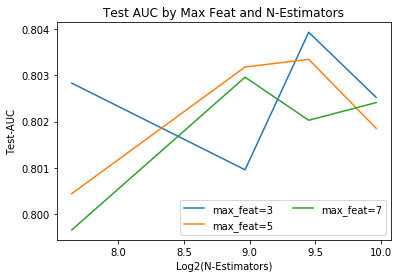

In [67]:
x = np.log2(np.array(n_est))
for m in m_feat:
    plt.plot(x, aucs_test[m], label='max_feat={}'.format(m))
    
plt.title('Test AUC by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('Test-AUC')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

In [68]:
best_model = RandomForestClassifier(criterion='entropy', n_estimators=700, max_features=3,bootstrap='True',oob_score=True)

In [69]:
best_model.fit(X_train, y_train)

print("The accuracy of training set: {:.3f}".format(best_model.score(X_train, y_train)))
print("The accuracy of test set: {:.3f}".format(best_model.score(X_test, y_test)))

The accuracy of training set: 1.000
The accuracy of test set: 0.734


In [70]:
rf_acc = cross_val_score(best_model, X_test, y_test, cv=kfold, scoring = 'accuracy').mean()
print("Test accuacy for random forest is: ", rf_acc)

Test accuacy for random forest is:  0.7270625032046352


In [71]:
best_rf_probs = best_model.predict_proba(X_test)[:, 1]

fpr_rf_best, tpr_rf_best, threshold_rf_best = roc_curve(y_test, best_rf_probs)
roc_auc_rf_best = auc(fpr_rf_best, tpr_rf_best)

print("AUC for the best random forest is: ", roc_auc_rf_best)

AUC for the best random forest is:  0.8038531631317583


[]

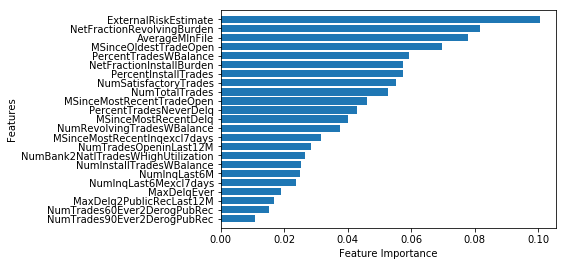

In [72]:
# Plot feature importance
%matplotlib inline

features = X.columns.values
n_features = X.shape[1]
indices = np.argsort(best_model.feature_importances_)

plt.barh(range(n_features), best_model.feature_importances_[indices], align='center')
plt.yticks(np.arange(n_features), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.ylim(-1, n_features)
plt.plot()

In [73]:
feature_importances = pd.DataFrame(best_model.feature_importances_, index = X.columns.values,
                                    columns=['Importance']).sort_values('Importance', ascending=False)
feature_importances

,Importance
ExternalRiskEstimate,0.100460
NetFractionRevolvingBurden,0.081753
AverageMInFile,0.077750
MSinceOldestTradeOpen,0.069679
PercentTradesWBalance,0.059200
NetFractionInstallBurden,0.057408
PercentInstallTrades,0.057329
NumSatisfactoryTrades,0.055196
NumTotalTrades,0.052756
MSinceMostRecentTradeOpen,0.045982


### Feature Reduction (not needed)

<generator object <genexpr> at 0x1022bfe08>


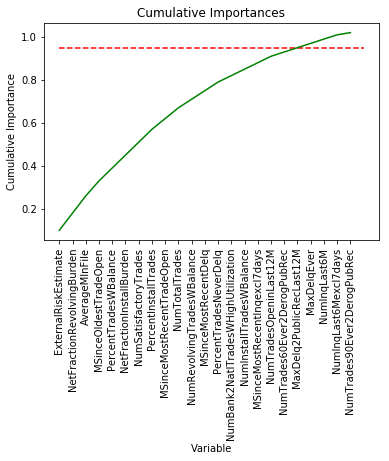

In [74]:
importances = list(best_model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse = True)

print('Variable: {:20} Importance: {}'.format(*pair) for pair in feature_importances)

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(list(range(len(importances))), cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(list(range(len(importances))), sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [75]:
print('Number of features for 80% importance:', np.where(cumulative_importances>0.80)[0][0]+1)

Number of features for 80% importance: 14


### Ada Boost Classifier

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
Ada = AdaBoostClassifier(n_estimators=50)
Ada_model = Ada.fit(X_train, y_train)

scores = cross_val_score(Ada_model, X_train, y_train)
scores.mean()

0.7234042553191489

In [77]:
# Accuracy, ptr,ftr, thresold, and AUC for Ada Boost
kfold = KFold(n_splits=10, random_state = 42)
ada_cv_acc = cross_val_score(Ada_model, X_test, y_test, cv=kfold, scoring = 'accuracy').mean()
print("Test accuacy for ada boost classifier is: ", ada_cv_acc)
y_prob_ada = Ada_model.predict_proba(X_test)[:, 1]
fpr_ada, tpr_ada, threshold = roc_curve(y_test, y_prob_ada)
roc_auc_ada = auc(fpr_ada, tpr_ada)
print("AUC for ada boost classifier is: ", roc_auc_ada)

Test accuacy for ada boost classifier is:  0.7108624314208072
AUC for ada boost classifier is:  0.7958890895530668


In [78]:
# Ada Boost with Grid Search
param_grid = {
              'n_estimators': [50, 100],
              'learning_rate' : [0.01,0.05,0.1,0.3,1]
             }
grid_search_Ada = GridSearchCV(Ada_model, param_grid=param_grid, scoring = 'accuracy',cv=4)
grid_search_Ada.fit(X_train,y_train)
print(grid_search_Ada.best_params_)

{'learning_rate': 0.3, 'n_estimators': 100}


In [79]:
# Accuracy, ptr,ftr, thresold, and AUC for Ada Boost w Grid Search
ada_grid_acc = cross_val_score(grid_search_Ada, X_test, y_test, cv=kfold, scoring = 'accuracy').mean()
print("Test accuacy for ada boost classifier is: ", ada_grid_acc)
y_prob_ada2 = grid_search_Ada.predict_proba(X_test)[:, 1]
fpr_ada2, tpr_ada2, threshold_ada2 = roc_curve(y_test, y_prob_ada2)
roc_auc_ada2 = auc(fpr_ada2, tpr_ada2)
print("AUC for ada boost classifier is: ", roc_auc_ada2)

Test accuacy for ada boost classifier is:  0.7270701943290775
AUC for ada boost classifier is:  0.8012577123872805


### Neural Network

In [80]:
# Neural Network
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)
mlp_model = mlp.fit(X_train,y_train)

print(mlp.score(X_train, y_train))
predictions = mlp.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0.7684903748733536
[[675 271]
 [263 766]]
             precision    recall  f1-score   support

          0       0.72      0.71      0.72       946
          1       0.74      0.74      0.74      1029

avg / total       0.73      0.73      0.73      1975



In [81]:
#print('test accuracy:', accuracy_score(y_test, predictions))
# accuracy, ptr,ftr, thresold, and AUC for neural network
kfold = KFold(n_splits=10, random_state = 42)
mlp_cv_acc = cross_val_score(mlp_model, X_test, y_test, cv=kfold, scoring = 'accuracy').mean()
print("Test accuacy for neural network is: ", mlp_cv_acc)
y_prob_mlp = mlp_model.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, threshold = roc_curve(y_test, y_prob_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
print("AUC for ada boost classifier is: ", roc_auc_mlp)

Test accuacy for neural network is:  0.7108649951289545
AUC for ada boost classifier is:  0.799641269978242


In [82]:
# neural network with grid search
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}


mlp_grid = GridSearchCV(mlp_model, parameter_space, n_jobs=-1, cv=4)
mlp_grid.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.0001, 0.05], 'learning_rate': ['constant', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [83]:
# accuracy, ptr,ftr, thresold, and AUC for neural network
kfold = KFold(n_splits=10, random_state = 42)
mlp_grid_acc = cross_val_score(mlp_grid, X_test, y_test, cv=kfold, scoring = 'accuracy').mean()
print("Test accuacy for neural network is: ", mlp_grid_acc)

Test accuacy for neural network is:  0.7356816899964108


In [84]:
y_prob_mlp2 = mlp_grid.predict_proba(X_test)[:, 1]
fpr_mlp2, tpr_mlp2, threshold2 = roc_curve(y_test, y_prob_mlp2)
roc_auc_mlp2 = auc(fpr_mlp2, tpr_mlp2)
print("AUC for neural network with Grid Search is: ", roc_auc_mlp2)

AUC for neural network with Grid Search is:  0.8088499066192469


#### c.f.

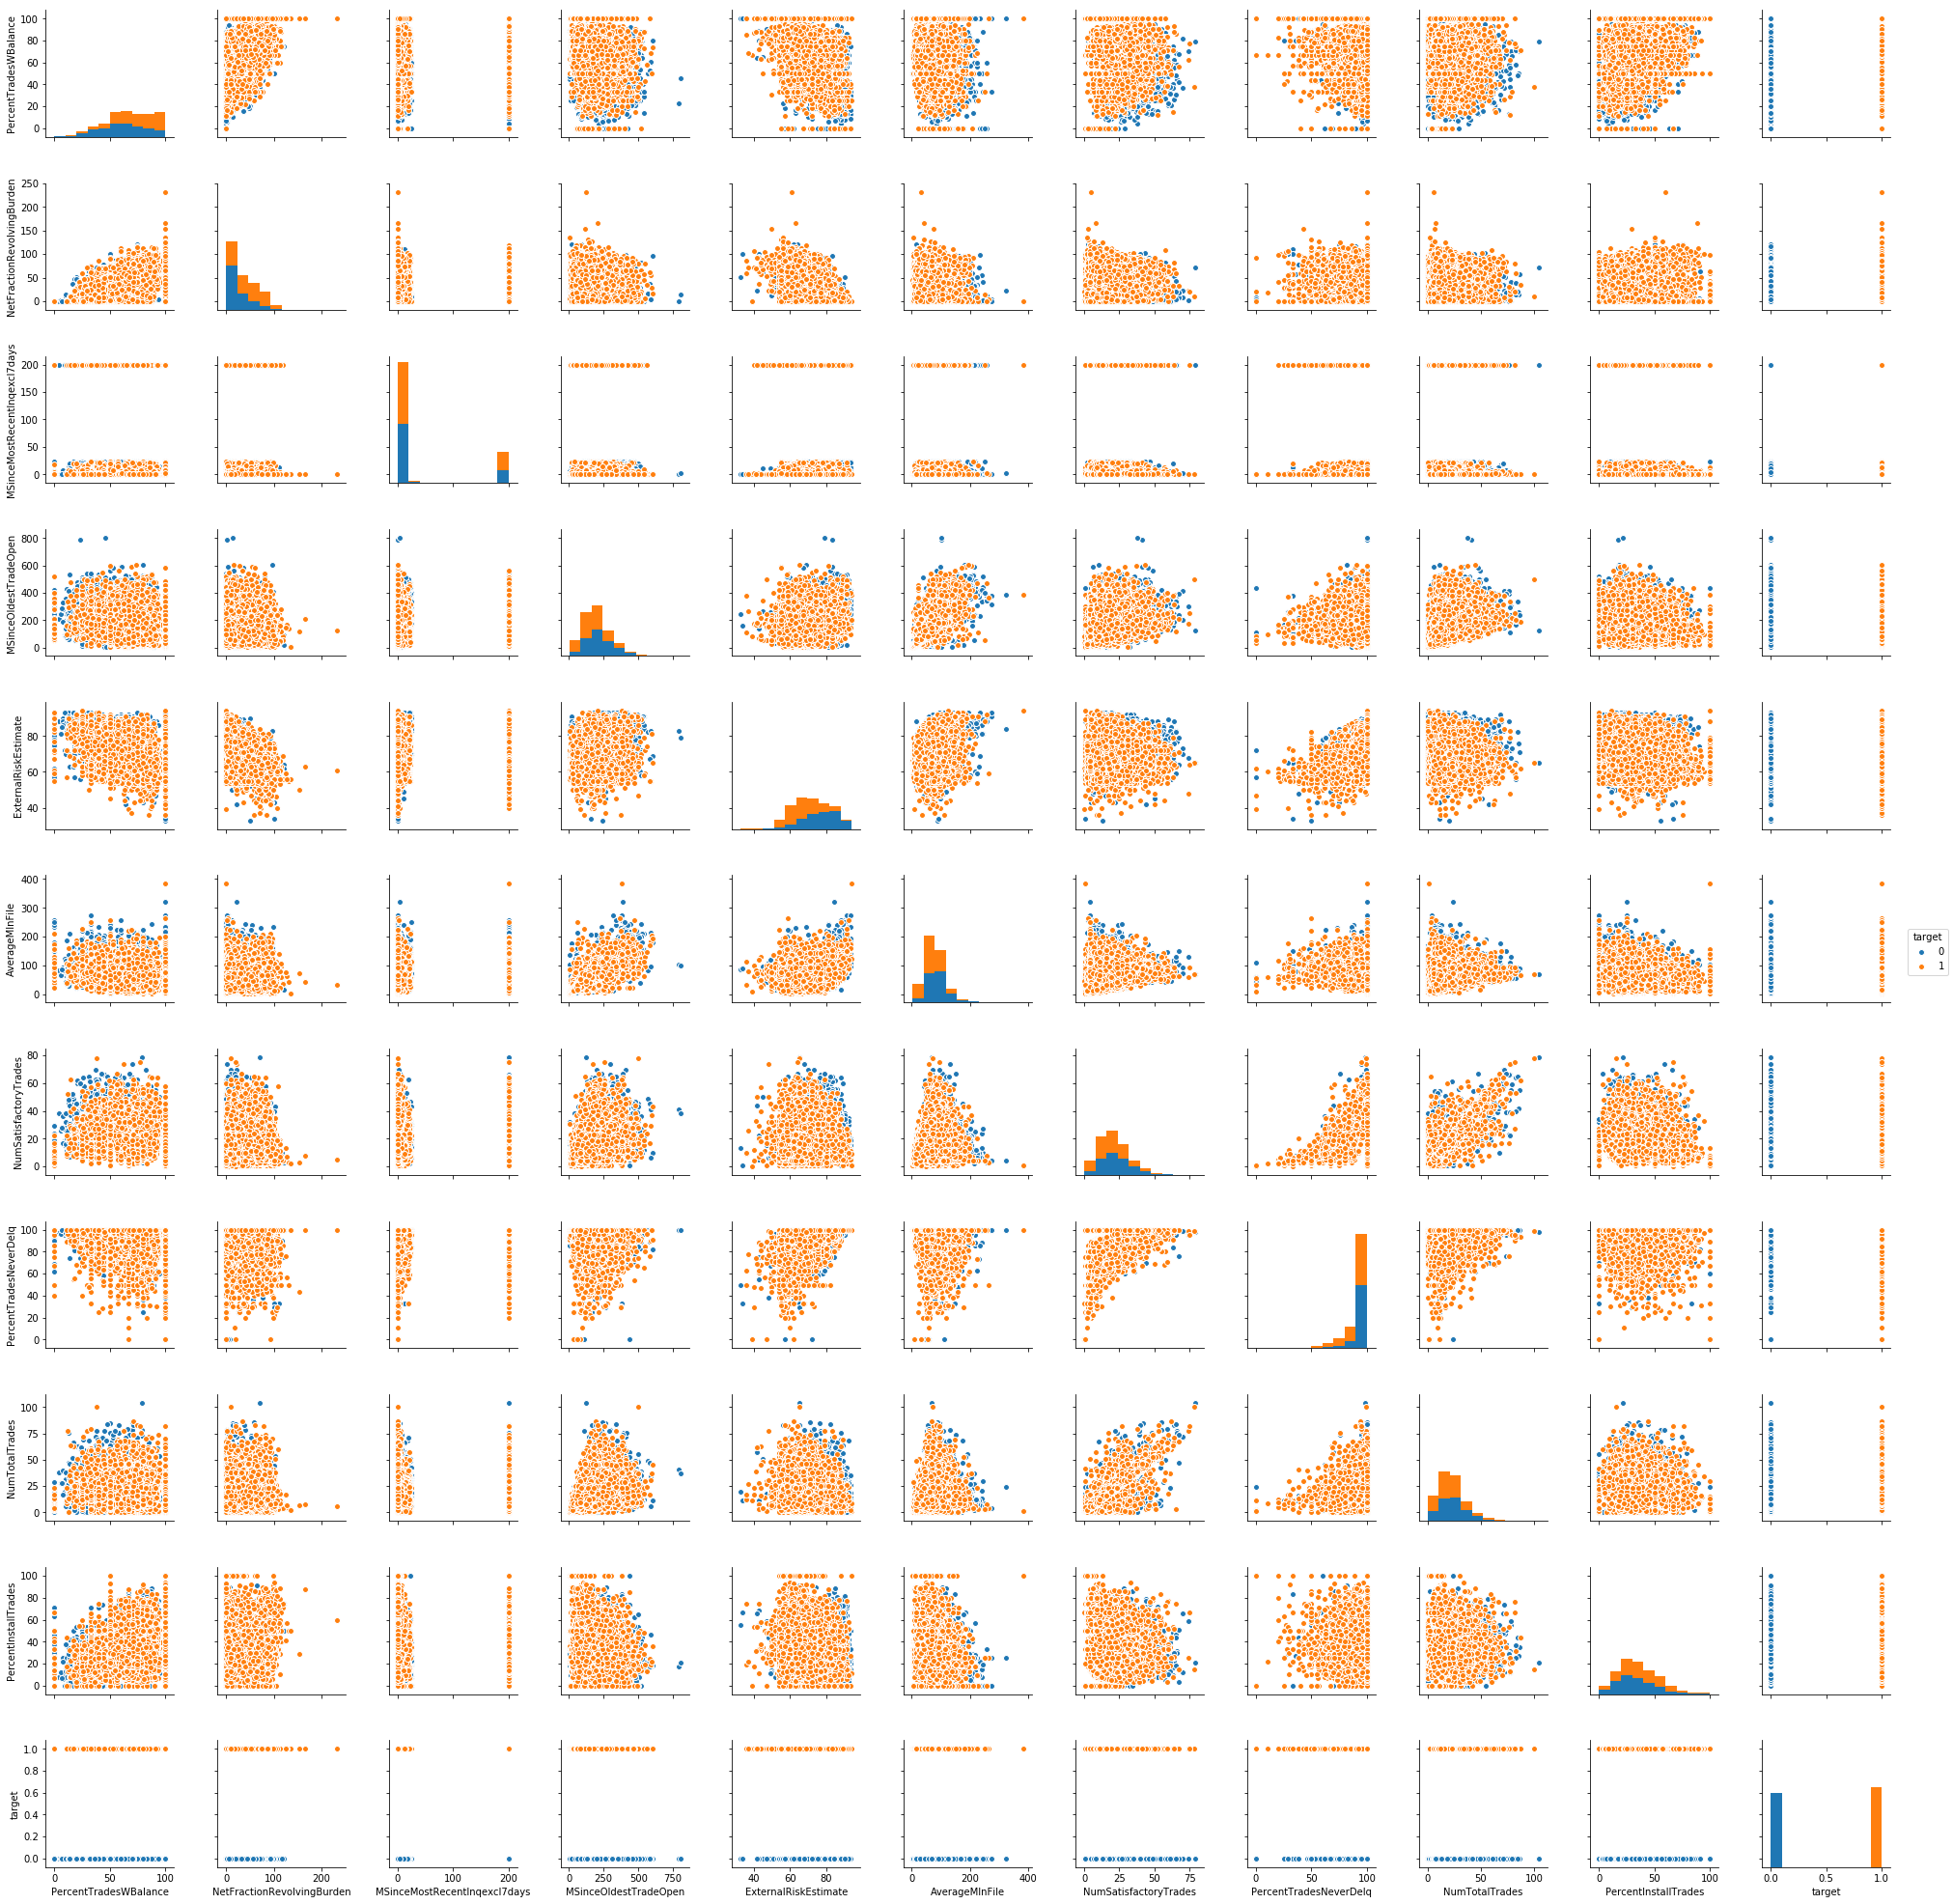

In [85]:
#I changed cleaned to df - please double check -> You are right!! thx!
import seaborn as sns
sns.pairplot(df.drop(['MSinceMostRecentTradeOpen', 'NetFractionInstallBurden','MSinceMostRecentDelq', 
                          'NumRevolvingTradesWBalance','NumBank2NatlTradesWHighUtilization',
                          'NumTradesOpeninLast12M','NumInstallTradesWBalance','NumInqLast6M','NumInqLast6Mexcl7days', 'MaxDelqEver',
                           'MaxDelq2PublicRecLast12M', 'NumTrades60Ever2DerogPubRec','NumTrades90Ever2DerogPubRec'], axis=1), hue='target')

In [86]:
train = df.sample(frac=0.8)
test = df.loc[~df.index.isin(train.index), :]
list(df.drop('target',1))

['PercentTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'NumInstallTradesWBalance',
 'NumRevolvingTradesWBalance',
 'NetFractionInstallBurden',
 'NetFractionRevolvingBurden',
 'MSinceMostRecentInqexcl7days',
 'MSinceMostRecentDelq',
 'MSinceOldestTradeOpen',
 'ExternalRiskEstimate',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades60Ever2DerogPubRec',
 'NumTrades90Ever2DerogPubRec',
 'PercentTradesNeverDelq',
 'MaxDelq2PublicRecLast12M',
 'MaxDelqEver',
 'NumTotalTrades',
 'NumTradesOpeninLast12M',
 'PercentInstallTrades',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days']

## Models Comparison & Evaluation

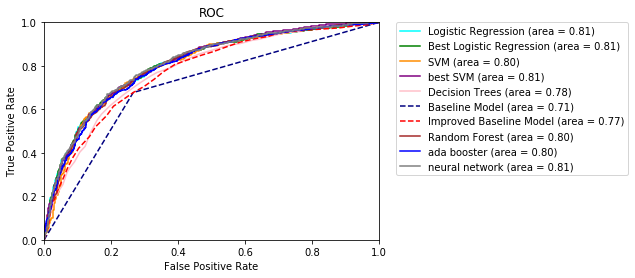

In [87]:
#ZC -to compare the models so far based on roc and auc
plt.figure()

plt.plot(fpr_logit, tpr_logit,color='aqua', label='Logistic Regression (area = %0.2f)' % roc_auc_logit)
plt.plot(fpr_logreg, tpr_logreg,color='green', label='Best Logistic Regression (area = %0.2f)' % roc_auc_logreg)
plt.plot(fpr_svm, tpr_svm,color='darkorange',label='SVM (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_svm_best, tpr_svm_best,color='purple',label='best SVM (area = %0.2f)' % roc_auc_svm_best)
plt.plot(fpr_dt_2, tpr_dt_2,color='pink',label='Decision Trees (area = %0.2f)' % roc_auc_dt_2)
plt.plot(fpr_base, tpr_base, color='navy', linestyle='--',label='Baseline Model (area = %0.2f)' % roc_auc_base)
plt.plot(fpr_base_2, tpr_base_2, color='red', linestyle='--',label='Improved Baseline Model (area = %0.2f)' % roc_auc_base_2)
plt.plot(fpr_rf_best, tpr_rf_best, color='brown', label='Random Forest (area = %0.2f)' % roc_auc_rf_best)
plt.plot(fpr_ada2, tpr_ada2, color='blue', label='ada booster (area = %0.2f)' % roc_auc_ada2)
plt.plot(fpr_mlp2, tpr_mlp2, color='grey', label='neural network (area = %0.2f)' % roc_auc_mlp2)
plt.plot()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Evaluation - sunjoo

Logistc Regression: 0.730600 (0.024474)
svm: 0.733151 (0.013815)
Decision Tree: 0.716951 (0.028944)
Random Forest: 0.725552 (0.024016)
Ada Boost: 0.727070 (0.016835)
Neural Networks: 0.730611 (0.018697)


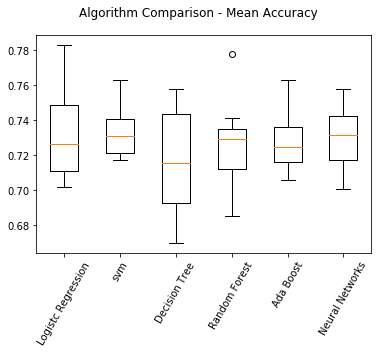

In [88]:
from sklearn.model_selection import cross_val_score

models = []
models.append(('Logistc Regression', best_grid_2))
models.append(('svm', best_grid_svm))
models.append(('Decision Tree', df_entropy_new))
models.append(('Random Forest',best_model))
models.append(('Ada Boost', grid_search_Ada))
models.append(('Neural Networks', mlp_grid))

results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state = 42)
    cv_results = cross_val_score(model, X_test, y_test, cv=kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' %(name, cv_results.mean(),cv_results.std())
    print(msg)
    
fig = plt.figure()
fig.suptitle('Algorithm Comparison - Mean Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names,rotation=60)
plt.show()

### Cost and Benefit Analysis (Expectation)

The simplified version of expected profit and loss:
tpr: high-risk people are correctly identified and are denied with loan extentions.

profit and cost implication: no major loss. just a small sevice fee: assume it takes one week to review the loan by a full-time banker and there's no additional cost other than his/her salary, then the cost is  $30∗9∗5=$1350$ per applicant for the bank

fpr: low-risk people are incorrect identified as high-risk people and are denied with loan extentions

profit and cost implication: same as tpr, small service fee =  $1350$per applicant for the bank

tnr: people with low-risk are approved with their loan application

profit and cost implication: assume everyone is applying for a  $200K$ loan with a 30 year fixed rate. under the current market, interest is on average  $4.7\%$ (annualized rate) which means an expected revenue of  $173K$ at the end of the 30 years payment. In the meantime, the cost would be the borrowing cost for the bank on this amount. let's assume the bank is borrowing from the fed with a current rate of  $3.32\%$ in concensus with the yield on 30 year treasury bond. After including this cost plus the service fee, the expected profit is  $43K$  after have each monthly payment discounted back for each applicant.

fnr: people with high-risk are approved with their loan application

profit and cost implication: In the simple case, we also assume that such applicant will default before the first payment, meaning we lose all the notional  $200K$ , in addition we need to pay back the interest amount for the $200K$ borrowed from the fed. However, since the loan is for home owners, one can at least assume that the bank can get the house back as a collateral and have part of the notional back to pay back fed (i.e,foreclosure). Let's assume that the bank incur a cost of  $10\%$ of the notional plus the service in this case.

In [89]:
def monthly_payment(total,apr):
    if apr == 0:
        return total / 30 / 12
    r = apr / 12 /100
    return r * total / (1 - (1+r)**(-12*30))

In [90]:
monthly_payment(200000,4.7) * 12 * 30

373419.22279631044

In [91]:
p_m = monthly_payment(200000,4.7) - monthly_payment(200000, 3.32)
p_m

159.1607905937292

In [92]:
profit = 0
for i in range(30*12):
    profit += p_m*math.exp(-2/100/12*i)

In [93]:
profit

43122.81374575108

In [94]:
200000*0.1

20000.0

In [95]:
#PnL function(Profit and Loss)
def expectedPNL(fpr,tpr,fnr,tnr,n):
    return n*(fpr*(-1350) + tpr*(-1350) + tnr*(43123-1350) - fnr*(1350+200000*0.1))

In [96]:
#function to scale population instances based on the ranking: for xlabel
def scale_n(pred,thresholds):
    row_n = []
    row_n.append(0)
    pred_list = list(pred)
    for t in thresholds[1:]:
        row_n.append(sum([1 for x in pred_list if x>=t]))
    size_n = [x/len(X_test) for x in row_n]
    return size_n

In [97]:
size_logit = scale_n(logit_pred,thresholds_logit)
size_logreg_best = scale_n(logreg_pred,thresholds_logreg)
size_svm = scale_n(svm_pred,thresholds_svm)
size_svm_best = scale_n(svm_pred_best,thresholds_svm_best)
size_dt = scale_n(dt_pred_2,thresholds_dt_2)
size_rf= scale_n(best_rf_probs,threshold_rf_best)
size_ada = scale_n(y_prob_ada2,threshold_ada2)
size_mlp = scale_n(y_prob_mlp2,threshold2)

In [98]:
#calculate PnL per tpr and fpr
PnL_logit = []
PnL_logreg = []
PnL_svm = []
PnL_svm_best = []
PnL_base = []
PnL_dt = []
PnL_rf = []
PnL_base_improved = []
PnL_ada = []
PnL_mlp = []

for i in range(len(tpr_logit)):
    PnL_logit.append(expectedPNL(fpr_logit[i],tpr_logit[i], 1-tpr_logit[i],1-fpr_logit[i],(size_logit[i])*len(X_test)))
    
#improved logit
for i in range(len(tpr_logreg)):
    PnL_logreg.append(expectedPNL(fpr_logreg[i],tpr_logreg[i], 1-tpr_logreg[i],1-fpr_logreg[i],(size_logreg_best[i])*len(X_test)))
    
for i in range(len(tpr_svm)):
    PnL_svm.append(expectedPNL(fpr_svm[i],tpr_svm[i], 1-tpr_svm[i],1-fpr_svm[i], (size_svm[i])*len(X_test)))
#svm best grid search
for i in range(len(tpr_svm_best)):
    PnL_svm_best.append(expectedPNL(fpr_svm_best[i],tpr_svm_best[i], 1-tpr_svm_best[i],1-fpr_svm_best[i], (size_svm_best[i])*len(X_test)))
    
for i in range(len(tpr_base)):
    PnL_base.append(expectedPNL(fpr_base[i],tpr_base[i], 1-tpr_base[i],1-fpr_base[i],(size_pred[i])*len(X_test)))
#improved baseline
for i in range(len(tpr_base_2)):
    PnL_base_improved.append(expectedPNL(fpr_base_2[i],tpr_base_2[i],1-tpr_base_2[i],1-fpr_base_2[i],(n_pred_base_2[i])*len(X_test)))
#improved decision tree   
for i in range(len(tpr_dt_2)):
    PnL_dt.append(expectedPNL(fpr_dt_2[i],tpr_dt_2[i],1-tpr_dt_2[i],1-fpr_dt_2[i],(size_dt[i])*len(X_test)))    
for i in range(len(tpr_rf_best)):
    PnL_rf.append(expectedPNL(fpr_rf_best[i],tpr_rf_best[i],1-tpr_rf_best[i],1-fpr_rf_best[i],(size_rf[i])*len(X_test)))  
#ada   
for i in range(len(tpr_ada2)):
    PnL_ada.append(expectedPNL(fpr_ada2[i],tpr_ada2[i],1-tpr_ada2[i],1-fpr_ada2[i],(size_ada[i])*len(X_test))) 
#mlp
for i in range(len(tpr_mlp2)):
    PnL_mlp.append(expectedPNL(fpr_mlp2[i],tpr_mlp2[i],1-tpr_mlp2[i],1-fpr_mlp2[i],(size_mlp[i])*len(X_test))) 

In [99]:
x_logit = [x for x in size_logit]
x_logreg_best = [x for x in size_logreg_best]
x_svm = [x for x in size_svm]
x_svm_best = [x for x in size_svm_best]
x_rf = [x for x in size_rf]
x_base = [x for x in size_pred]
x_base_2 = [x for x in n_pred_base_2]
x_dt = [x for x in size_dt]
x_ada = [x for x in size_ada]
x_mlp = [x for x in size_mlp]

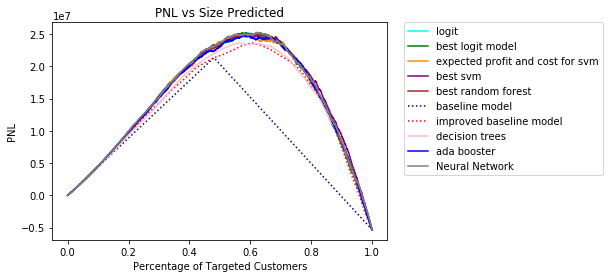

In [100]:
#plot
plt.figure()
plt.plot(x_logit, PnL_logit,color='aqua',label='logit')
plt.plot(x_logreg_best, PnL_logreg,color='green',label='best logit model')
plt.plot(x_svm, PnL_svm,color='darkorange',label='expected profit and cost for svm')
plt.plot(x_svm_best, PnL_svm_best,color='purple',label='best svm')
plt.plot(x_rf, PnL_rf,color='brown',label='best random forest')
plt.plot(x_base, PnL_base,color='navy',linestyle = ":",label='baseline model')
plt.plot(x_base_2, PnL_base_improved,color='red',linestyle = ":",label='improved baseline model')
plt.plot(x_dt, PnL_dt,color='pink',label='decision trees')
plt.plot(x_ada, PnL_ada,color='blue',label='ada booster')
plt.plot(x_mlp, PnL_mlp,color='grey',label='Neural Network')
plt.xlabel('Percentage of Targeted Customers')
plt.ylabel('PNL')
plt.title('PNL vs Size Predicted')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [101]:
#find the optimal PnL

PnL_list = [max(PnL_logit),max(PnL_logreg),max(PnL_svm),max(PnL_svm_best),max(PnL_base),max(PnL_dt),max(PnL_rf),max(PnL_base_improved),max(PnL_ada),max(PnL_mlp)]

print("The optimal PnL was achieved by: ", PnL_list.index(max(PnL_list)))
print("The max PnL is: ", max(PnL_list))
PnL_list
#so neural network gives the optimal PnL

The optimal PnL was achieved by:  9
The max PnL is:  25280843.371032853


[25219272.04140394,
 25180494.57968388,
 24825808.581398427,
 24922058.68633313,
 21336198.416535687,
 23623094.54784197,
 25108411.43010312,
 23626653.01438002,
 24835752.532426443,
 25280843.371032853]

In [102]:
#zoom in the optimal region, which is roughly between[0.5,0.8] for x
#determine the data needed.

def zoom(xlist,lower,upper):
    n = len(xlist)
    a = xlist.index(xlist[int(lower*len(xlist))])
    b = xlist.index(xlist[int(upper*len(xlist))])
    return [a,b]

In [103]:
#re-indexing
x_logit_zoom = zoom(x_logit,0.5,0.8)
x_logreg_zoom = zoom(x_logreg_best,0.5,0.8)
x_svm_zoom = zoom(x_svm,0.5,0.8)
x_svm_best_zoom = zoom(x_svm_best, 0.5,0.8)
x_rf_zoom = zoom(x_rf, 0.5,0.8)
x_base_zoom = zoom(x_base,0.5,0.8)
x_base_2_zoom = zoom(x_base_2,0.5,0.8)
x_dt_zoom = zoom(x_dt,0.5,0.8)
x_ada_zoom = zoom(x_ada,0.5,0.8)
x_mlp_zoom = zoom(x_mlp,0.5,0.8)

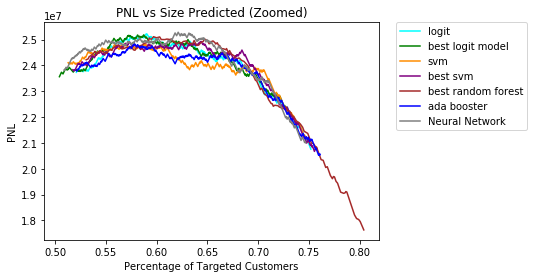

In [104]:
plt.figure()
plt.plot(x_logit[x_logit_zoom[0]:x_logit_zoom[1]], PnL_logit[x_logit_zoom[0]:x_logit_zoom[1]],color='aqua',label='logit')
plt.plot(x_logreg_best[x_logreg_zoom[0]:x_logreg_zoom[1]], PnL_logreg[x_logreg_zoom[0]:x_logreg_zoom[1]],color='green',label='best logit model')
plt.plot(x_svm[x_svm_zoom[0]:x_svm_zoom[1]], PnL_svm[x_svm_zoom[0]:x_svm_zoom[1]],color='darkorange',label='svm')
plt.plot(x_svm_best[x_svm_best_zoom[0]:x_svm_best_zoom[1]], PnL_svm_best[x_svm_best_zoom[0]:x_svm_best_zoom[1]],color='purple',label='best svm')
plt.plot(x_rf[x_rf_zoom[0]:x_rf_zoom[1]], PnL_rf[x_rf_zoom[0]:x_rf_zoom[1]],color='brown',label='best random forest')
#plt.plot(x_base[x_base_zoom[0]:x_base_zoom[1]], PnL_base[x_base_zoom[0]:x_base_zoom[1]],color='navy',linestyle = ":",label='expected profit and cost for baseline model')
#plt.plot(x_base_2[x_base_2_zoom[0]:x_base_2_zoom[1]], PnL_base_improved[x_base_2_zoom[0]:x_base_2_zoom[1]],color='red',linestyle = ":",label='expected profit and cost for improved baseline model')
#plt.plot(x_dt[x_dt_zoom[0]:x_dt_zoom[1]], PnL_dt[x_dt_zoom[0]:x_dt_zoom[1]],color='pink',label='expected profit and cost for decision trees')
plt.plot(x_ada[x_ada_zoom[0]:x_ada_zoom[1]], PnL_ada[x_ada_zoom[0]:x_ada_zoom[1]],color='blue',label='ada booster')
plt.plot(x_mlp[x_mlp_zoom[0]:x_mlp_zoom[1]], PnL_mlp[x_mlp_zoom[0]:x_mlp_zoom[1]],color='grey',label='Neural Network')
plt.xlabel('Percentage of Targeted Customers')
plt.ylabel('PNL')
plt.title('PNL vs Size Predicted (Zoomed)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Measure the tradeoff (for Extra Point!!)
between sparse linear model vs. black box model(i.e., what is the cost of explainability) 

### Cluster Analysis

- feature engineering
- discretization
- regularization: solve overfitting
- scale(normalization)
- cross validation
- Grid search to find the optimal hyper-parameter

**Reference**: https://community.fico.com/s/explainable-machine-learning-challenge
